# Laboratorio 08 - Análisis y preparación de texto

En este laboratorio vemos cómo pre-procesar el texto, cómo generar BoW y embeddings además de correr una red neuronal inicial. El foco del laboratorio es en el pre-procesamiento, otros laboratorios cubrirán más sobre el modelado.
Es por eso que no se evalúa el modelo y no se tienen división de train/test/validation, en otros laboratorios cubriremos esto.

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

import unicodedata
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter


# 01. Datos
Ejemplo de texto generado. Asumamos que tenemos 5 observaciones en el contexto de evaluación del curso de ciencia de datos y los hemos categorizado en positivos (1) y negativos (0). Queremos con una red neuronal crear un modelo que en el futuro nos ayude a clasificar estos comentarios automáticamente sin tener que leerlos uno por uno.

In [17]:

# Sample data
data = {
    'text': [
        'El curso es aburrido. No le encuentro sentido al material',
        'Me encanta la ciencia de datos, es mi curso favorito. Le doy un 10 de 10.',
        'Estoy emocionada por aplicar redes neuronales en el futuro. Deseo aprender más del tema aunque sea complicado',
        'Programar modelos de lenguaje es divertido, no me parece difícil y es muy útil',
        'Odio el aprendizaje profundo!! Es mejor eliminar este curso'
    ],
    'label': [0, 1, 1, 1, 0]  # O es un mal comentario y 1 un buen comentario
}

# Create DataFrame
df = pd.DataFrame(data)
df

,text,label
0,El curso es aburrido. No le encuentro sentido ...,0
1,"Me encanta la ciencia de datos, es mi curso fa...",1
2,Estoy emocionada por aplicar redes neuronales ...,1
3,"Programar modelos de lenguaje es divertido, no...",1
4,Odio el aprendizaje profundo!! Es mejor elimin...,0


## 02. Preparación de datos
En la teoría vimos distintos pasos para pre-procesar y llegar al formato necesario para las redes neuronales. En este texto, vamos a aplicar la mayoría de estas:
1. Todo a minúsculas
2. Eliminar números/puntuación
3. Eliminar stop words
4. Tokenizar el texto
5. Stem/lemmatization
6. Crear vocabulario
7. Homogenizar el largo usando padding
8. Crear BoW/embedding/ embedding pre-entrenado
9. Correr un modelo

En la siguiente función cambiamos a minúscula, quitamos acentos y ciertos caracteres de puntuación

In [18]:
# Limpieza: minusculas, quitar comas y puntos y acentos
def preprocess_text(text):
    # Remove accents
    text = ''.join(
        (c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn')
    )

    # Convert to lowercase
    text = text.lower()

    # Remove dots and commas, but keep other punctuation
    text = re.sub(r'[.,]', '', text)

    return text

# Apply the function to each text entry
df['text'] = df['text'].apply(preprocess_text)
print(df['text'].values)

['el curso es aburrido no le encuentro sentido al material'
 'me encanta la ciencia de datos es mi curso favorito le doy un 10 de 10'
 'estoy emocionada por aplicar redes neuronales en el futuro deseo aprender mas del tema aunque sea complicado'
 'programar modelos de lenguaje es divertido no me parece dificil y es muy util'
 'odio el aprendizaje profundo!! es mejor eliminar este curso']


Visualización de la aparición de palabras en cada clase

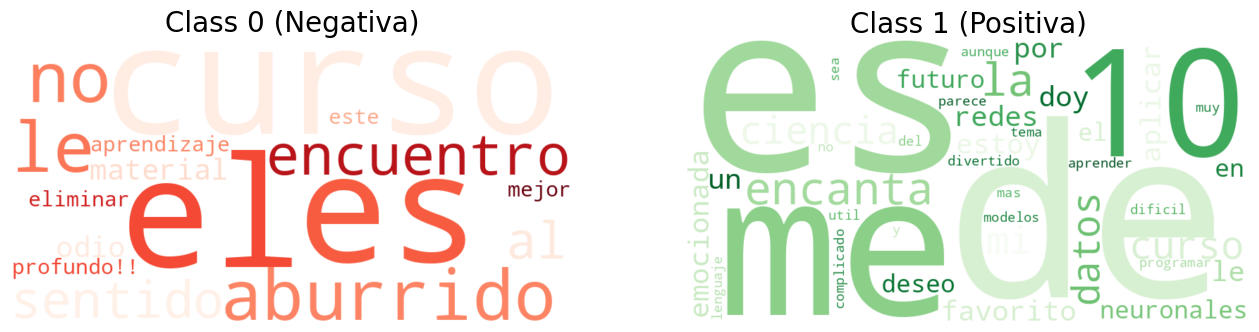

In [4]:
# Hacer visualización en word cloud

# División basada en clase
text_0 = ' '.join(df[df['label'] == 0]['text'])
text_1 = ' '.join(df[df['label'] == 1]['text'])

# Frecuencia de palabras por clase
word_freq_0 = Counter(text_0.split())
word_freq_1 = Counter(text_1.split())

# Crear ambas nubes de palabras
wordcloud_0 = WordCloud(width=800, height=400, colormap='Reds', background_color='white').generate_from_frequencies(word_freq_0)
wordcloud_1 = WordCloud(width=800, height=400, colormap='Greens', background_color='white').generate_from_frequencies(word_freq_1)

# Gráficos
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.title('Class 0 (Negativa)', fontsize=20)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('Class 1 (Positiva)', fontsize=20)
plt.axis('off')
plt.show()

Podemos ver que hay palabras que no nos son útiles y salen altamente representadas, por ejemplo "el", "de", "me". Por lo que procedemos a eliminarloas como "stopwords"

In [24]:
# Lista de palabras
stopwords = ['de', 'me', 'el']

# Función
def remove_stopwords(text, stopwords):
    return ' '.join([word for word in text.split() if word not in stopwords])

# Aplicar la función en el texto
df['text'] = df['text'].apply(lambda x: remove_stopwords(x, stopwords))

,text
0,curso es aburrido no le encuentro sentido al m...
1,encanta la ciencia datos es mi curso favorito ...
2,estoy emocionada por aplicar redes neuronales ...
3,programar modelos lenguaje es divertido no par...
4,odio aprendizaje profundo!! es mejor eliminar ...


También podríamos usar diccionarios de stop words que existen en distintas librerías por idioma. Se debe ser cuidadoso con esta lista pues es general y puede que elimine alguna palabra que en el contexto en que se trabaja realmente es importante

In [25]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if you haven't already
nltk.download('stopwords')

# Get Spanish stopwords
spanish_stopwords = stopwords.words('spanish')
print(spanish_stopwords)

# Función con este diccionario
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in spanish_stopwords])

# Apply the function to the 'text' column
df['text'] = df['text'].apply(remove_stopwords)
print(df['text'].values)


['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Seguimos con la tokenización del texto

In [26]:
# con tokenizer de keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
# Convertir texto en secuencias
X = tokenizer.texts_to_sequences(df['text'])

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for padding

print(f"Texto como secuencias: {X}")
print(f"Tamaño del vocabulario {vocab_size}")

Texto como secuencias: [[1, 3, 4, 5], [6, 7, 8, 1, 9, 10, 2, 2], [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [22, 23, 24, 25, 26, 27, 28], [29, 30, 31, 32, 33, 1]]
Tamaño del vocabulario 34


Vamos a añadir padding basado en el máximo de largo que tenemos. A veces esto no es posible dado que tenemos textos muy largos y poco poder computacional. En este caso por ser corto y pocas observaciones lo podemos hacer

In [27]:
# Padding - encontrar el máximo y rellenar el resto
max_length = max(len(seq) for seq in X)
print(f"Máximo largo de secuencia: {max_length}")
X = pad_sequences(X, maxlen=max_length, padding='post')
X

Máximo largo de secuencia: 11


array([[ 1,  3,  4,  5,  0,  0,  0,  0,  0,  0,  0],
       [ 6,  7,  8,  1,  9, 10,  2,  2,  0,  0,  0],
       [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
       [22, 23, 24, 25, 26, 27, 28,  0,  0,  0,  0],
       [29, 30, 31, 32, 33,  1,  0,  0,  0,  0,  0]], dtype=int32)

### A. Entrenar con Bag of Words (BoW)

Bag of Words Matrix:
(5, 34)
[[1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 7.]
 [1. 2. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
  1. 1. 1. 1. 0. 0. 0. 0. 0. 4.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 1. 1. 1. 1. 5.]]
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2000 - loss: 0.7396
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2000 - loss: 0.7356
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2000 - loss: 0.7316
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2000 - loss: 0.7276
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2000 - loss: 0.7237
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2000 - loss: 0.7198
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2000 - loss: 0.7159
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2000 - loss: 0.7121
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4000 - loss: 0.7082
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4000 - loss: 0.7044


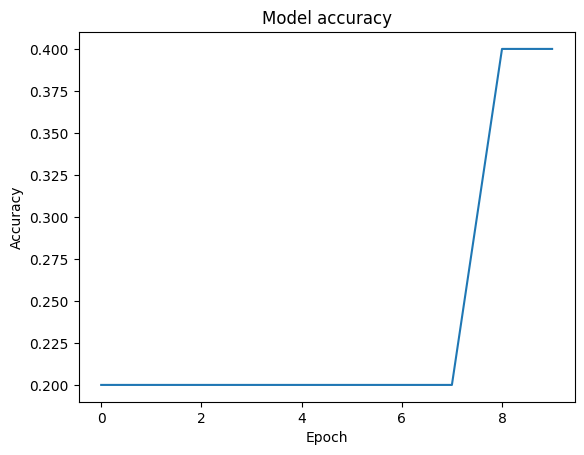

In [28]:
# Crear BoW
# Matriz con ceros
bow_matrix = np.zeros((len(df), vocab_size))

# Manualmente llenamos con el conteo
for i, seq in enumerate(X):
    for index in seq:
        bow_matrix[i, index - 1] += 1  # Increment count (index - 1 for zero indexing)

# Print the BoW matrix
print("Bag of Words Matrix:")
print(bow_matrix.shape)
print(bow_matrix)

# Step 3: Modelo MLP
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(vocab_size,)))  # Input shape is the vocabulary size
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compilar
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar
history = model.fit(bow_matrix, df["label"], epochs=10, verbose=1)

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### B. Entrenar con embedding

El parámetro *output_dim* indica el tamaño del vector de embedding de cada palabra. En este caso, cada palabra estará representada por un vector de 8 dimensiones. Esto significa que, para cualquier palabra del vocabulario, su embedding tendrá 8 características (o dimensiones).

La capa de embedding se puede considerar como una tabla de búsqueda simple que recupera embeddings para tokens de entrada. No se basa en un modelo tradicional como Word2Vec o GloVe, pero es un componente esencial que permite que los modelos trabajen con datos de texto tokenizados y aprenda las representaciones adecuadas en el proceso de entrenamiento de la red.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Tamaño de embedding generado: (5, 11, 8)
Ejemplo para primera palabra en primera oración: tf.Tensor(
[ 8.7681413e-03  4.3105334e-05  3.0878391e-02  1.7023850e-02
  3.6132898e-02 -2.1190131e-02 -3.3779182e-02 -4.3126941e-02], shape=(8,), dtype=float32)


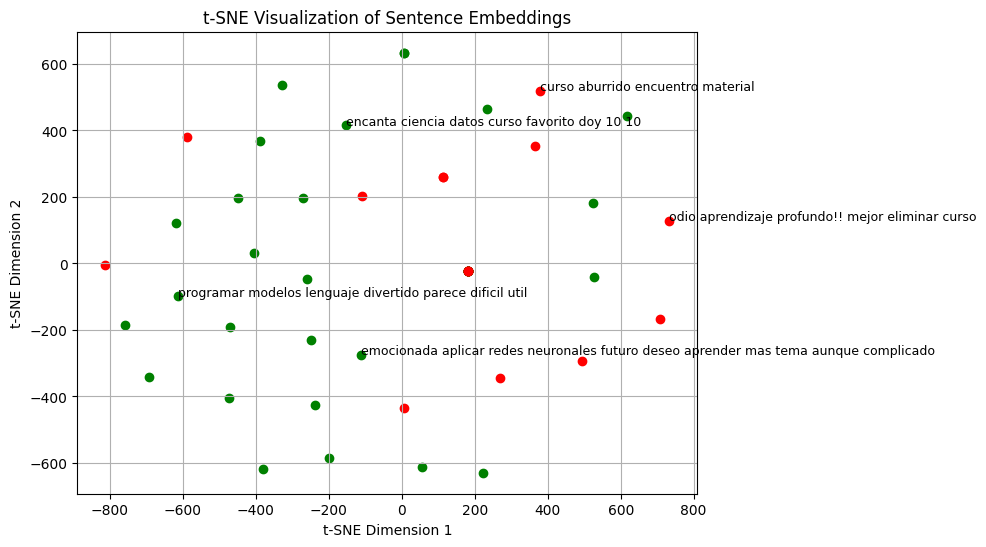

In [29]:
# Ejemplo de embedding y su tipo de resultado
from sklearn.manifold import TSNE

emb_k = Embedding(input_dim=vocab_size, output_dim=8, input_length=max_length)
print(f"Tamaño de embedding generado: {emb_k(X).shape}")
print("Ejemplo para primera palabra en primera oración:", emb_k(X)[0][0])

# Visualización con TSNE - modelo que reduce alta dimensionalidad (como PCA)
embedding_r = emb_k(X).numpy()
flattened_embeddings = embedding_r.reshape(-1, 8)  # Reshape to (5*10, 8)
tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(flattened_embeddings)

# Grafico
plt.figure(figsize=(8, 6))
for i in range(len(df)):
    indices = range(i * max_length, (i + 1) * max_length)
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1],
                c='green' if df['label'][i] == 1 else 'red',
                label='Positive' if df['label'][i] == 1 else 'Negative')

# Etiquetas
for i, txt in enumerate(df['text']):
    plt.annotate(txt, (reduced_embeddings[i * max_length, 0], reduced_embeddings[i * max_length, 1]), fontsize=9)

plt.title("t-SNE Visualization of Sentence Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid()
plt.show()

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6000 - loss: 0.6937
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6000 - loss: 0.6924
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6000 - loss: 0.6913
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6000 - loss: 0.6901
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6000 - loss: 0.6889
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6000 - loss: 0.6877
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6000 - loss: 0.6866
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6000 - loss: 0.6855
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6000 - loss: 0.6845
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6000 - loss: 0.6835


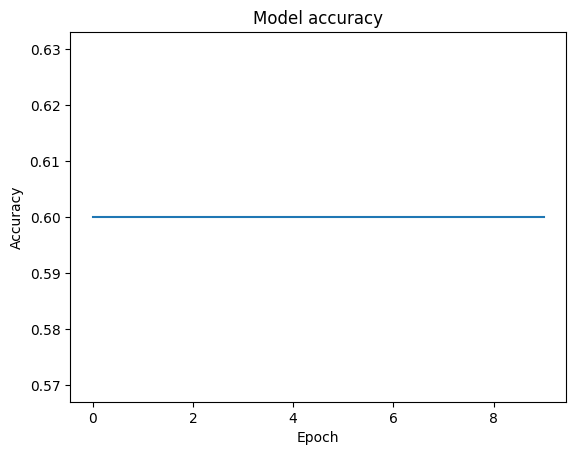

In [11]:

# Modelo de keras con el embedding
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=8, input_length=max_length))  # Word embeddings
model.add(GlobalAveragePooling1D())  # Pooling layer
model.add(Dense(56, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compilar
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar con X, NO bow
history = model.fit(X, df["label"], epochs=10, verbose=1)

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

Entrenar con embedding pre-entrenado en español - importante, debe ser en el idioma

In [30]:
import kagglehub
# Descargando de kaggle una versión de word2vec con datos en español
path = kagglehub.dataset_download("rtatman/pretrained-word-vectors-for-spanish")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/rtatman/pretrained-word-vectors-for-spanish/versions/1


In [31]:
# Busqueda del vocabulario
embedding_index = {}
with open(path + "/SBW-vectors-300-min5.txt") as f:
  for line in f:
    word, coef = line.split(maxsplit=1)
    coef = np.fromstring(coef, 'f', sep=' ')
    embedding_index[word] = coef
print('{} embeddings encontrados'.format(len(embedding_index)))


# Chequeos de cuantos fueron encontrados
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for w, i in tokenizer.word_index.items():
  embedding_vector = embedding_index.get(w)
  if embedding_vector is not None:
    hits+=1
    embedding_matrix[i] = embedding_vector
  else:
    print(f"Palabra no encontradas: {w}")
    misses += 1

print('{} palabras codificadas con un embedding en SBW-vectors'.format(hits))
print('{} embeddings de palabras no encontrados'.format(misses))




1000654 embeddings encontrados
Palabra no encontradas: 10
32 palabras codificadas con un embedding en SBW-vectors
1 embeddings de palabras no encontrados


Visualizar embeddings

Tamaño de embedding generado: (5, 11, 300)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


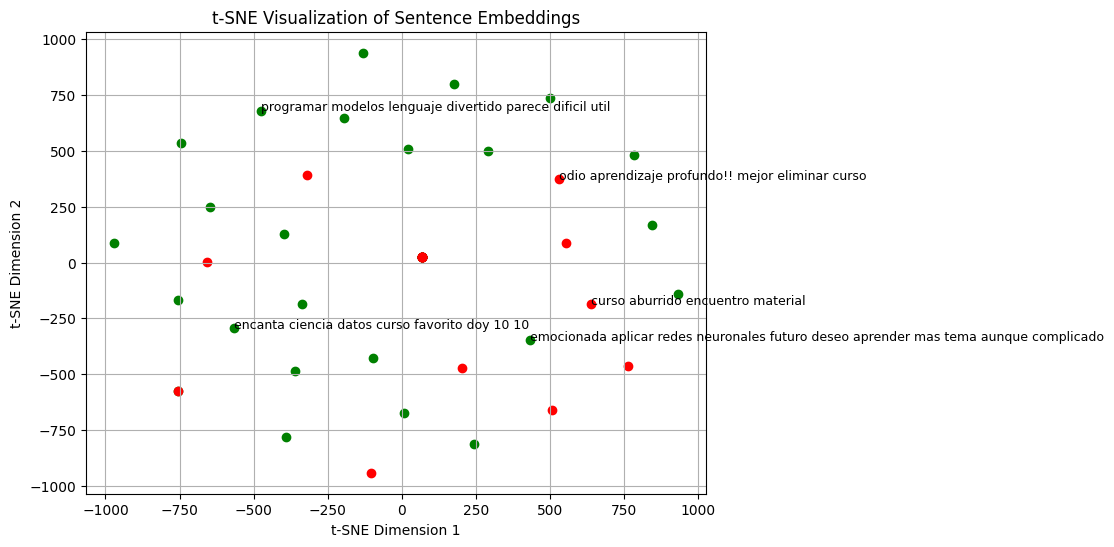

In [14]:
embedding_matrix.shape

from sklearn.manifold import TSNE
emb_pt = Embedding(input_dim=vocab_size,
                     embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                     mask_zero=True,
                     output_dim=embedding_dim, # dimension of dense embedding.
                     input_length=max_length)
print(f"Tamaño de embedding generado: {emb_pt(X).shape}")

# Visualización con TSNE - modelo que reduce alta dimensionalidad (como PCA)
embedding_r = emb_pt(X).numpy()
flattened_embeddings = embedding_r.reshape(-1, embedding_dim)  # Reshape to (5*10, 8)
tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(flattened_embeddings)

# Grafico
plt.figure(figsize=(8, 6))
for i in range(len(df)):
    indices = range(i * max_length, (i + 1) * max_length)
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1],
                c='green' if df['label'][i] == 1 else 'red',
                label='Positive' if df['label'][i] == 1 else 'Negative')

# Etiquetas
for i, txt in enumerate(df['text']):
    plt.annotate(txt, (reduced_embeddings[i * max_length, 0], reduced_embeddings[i * max_length, 1]), fontsize=9)

plt.title("t-SNE Visualization of Sentence Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid()
plt.show()

modelo

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6000 - loss: 0.6945
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6000 - loss: 0.6775
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8000 - loss: 0.6617
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 1.0000 - loss: 0.6464
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 1.0000 - loss: 0.6318
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 1.0000 - loss: 0.6177
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 1.0000 - loss: 0.6030
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 0.5876
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.5719
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.5560


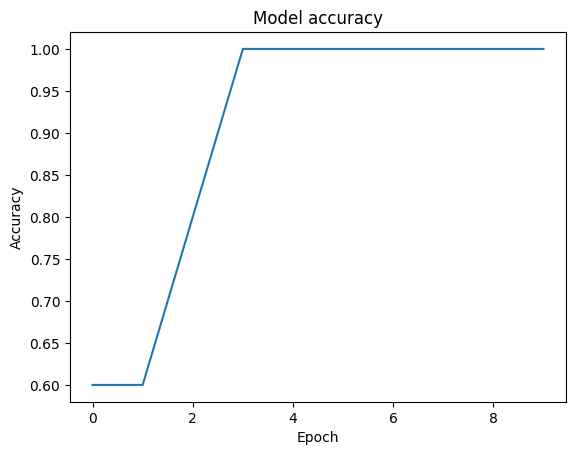

In [32]:
# Modelo de keras con el embedding
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                     embeddings_initializer=keras.initializers.Constant(embedding_matrix), # le damos la matriz
                     mask_zero=True,
                     output_dim=embedding_dim, # dimension of dense embedding.
                     input_length=max_length))
model.add(GlobalAveragePooling1D())  # Pooling layer
model.add(Dense(56, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compilar
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar
history = model.fit(X, df["label"], epochs=10, verbose=1)

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()